In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import numpy as np
import pandas as pd

from biobank_olink.dataset import load_olink_and_covariates

ol_df, cov_df = load_olink_and_covariates(cols_na_th=0.3, rows_na_th=0.3, corr_th=0.9)
cov_df = cov_df.loc[cov_df.HTNgroup.isin((0, 1))]
ol_df = ol_df.loc[cov_df.index]
cov_df.head(5)

[Memory]2533.0s, 42.2min: Loading load_olink_and_covariates...


,Sex,age,BMI,Smokinstatus,Alcoholintakefrequency,HTNgroup,fastingtime,SBP,DBP,PP
eid,,,,,,,,,,
1000366,1.0,66.0,23.7966,1.0,2.0,0.0,2.0,136.5,82.5,54.0
1000774,0.0,57.0,23.6146,0.0,2.0,0.0,2.0,135.0,72.5,62.5
1001182,0.0,62.0,26.7185,0.0,2.0,0.0,6.0,126.5,75.5,51.0
1001297,0.0,48.0,23.5351,0.0,1.0,0.0,4.0,124.0,78.5,45.5
1001306,0.0,43.0,35.6513,0.0,5.0,1.0,3.0,140.5,88.5,52.0


In [62]:
threshold = 0.35
target = "SBP"
lower_bound, upper_bound = cov_df[target].quantile([threshold, 1 - threshold]).values
low_cov_df = cov_df[cov_df[target] < lower_bound]
high_cov_df = cov_df[upper_bound < cov_df[target]]
pd.concat([low_cov_df[target].describe(), high_cov_df[target].describe()], axis=1,
          keys=["low", "high"])

,low,high
count,10542.000000,10287.000000
mean,117.761668,156.480461
std,7.385581,12.361779
min,76.500000,142.500000
25%,113.000000,147.000000
50%,119.500000,153.000000
75%,123.500000,162.500000
max,127.500000,246.000000


In [63]:
correction_df = pd.concat([low_cov_df, high_cov_df])
correction_cols = ["Sex", "age", "BMI"]
correction_df = correction_df[correction_cols]
correction_df = (correction_df - correction_df.mean()) / correction_df.std()
correction_df.head()

,Sex,age,BMI
eid,,,
1001182,-0.835260,0.716531,0.009213
1001297,-0.835260,-0.989503,-0.708789
1001846,-0.835260,-0.745784,-1.622836
1002241,1.197174,-0.380205,1.458705
1002948,1.197174,-1.842520,-1.384592


In [64]:
from scipy.spatial.distance import pdist, squareform

similarities = squareform(pdist(correction_df))
np.fill_diagonal(similarities, np.inf)
similarities_df = pd.DataFrame(similarities, index=correction_df.index, columns=correction_df.index)
similarities_sub_df = similarities_df.loc[low_cov_df.index, high_cov_df.index]

paired_up_df = similarities_sub_df.idxmin().to_frame("p2_id")
paired_up_df["dist"] = similarities_df.min()
paired_up_df2 = similarities_sub_df.T.idxmin().to_frame("p2_id")
paired_up_df2["dist"] = similarities_df.T.min()
paired_up_df = pd.concat([paired_up_df, paired_up_df2])
paired_up_df.sort_values(by="dist", inplace=True)

del similarities_df, similarities
paired_up_df.head()

,p2_id,dist
eid,,
5161063,4730342,0.0
5199204,3382820,0.0
3191713,4083575,0.0
5813523,1999307,0.0
5199714,4051869,0.0


In [65]:
chosen = set()
for p1_idx, (p2_idx, _) in paired_up_df.iterrows():
    if p1_idx in chosen or p2_idx in chosen:
        continue
    chosen.add(p1_idx)
    chosen.add(p2_idx)

chosen_cov_df = cov_df.loc[list(chosen)]
low_cov_df = chosen_cov_df[chosen_cov_df.SBP < lower_bound]
high_cov_df = chosen_cov_df[upper_bound < chosen_cov_df.SBP]
pd.concat([low_cov_df.SBP.describe(), high_cov_df.SBP.describe()], axis=1, keys=["low", "high"])

,low,high
count,5018.000000,5018.000000
mean,119.005181,155.668394
std,6.832653,12.066937
min,76.500000,142.500000
25%,115.000000,146.500000
50%,120.500000,152.500000
75%,124.500000,161.000000
max,127.500000,246.000000


In [66]:
pd.concat([low_cov_df[correction_cols].describe(), high_cov_df[correction_cols].describe()], axis=1,
          keys=["low", "high"])

low                                   high               \
               Sex          age          BMI          Sex          age   
count  5018.000000  5018.000000  5018.000000  5018.000000  5018.000000   
mean      0.432443    56.765843    26.818846     0.432443    56.768035   
std       0.495464     7.623750     4.286982     0.495464     7.623307   
min       0.000000    40.000000    15.353500     0.000000    40.000000   
25%       0.000000    51.000000    23.893150     0.000000    51.000000   
50%       0.000000    58.000000    26.247150     0.000000    58.000000   
75%       1.000000    63.000000    29.053550     1.000000    63.000000   
max       1.000000    70.000000    55.134100     1.000000    70.000000   

                    
               BMI  
count  5018.000000  
mean     26.820585  
std       4.290746  
min      15.657300  
25%      23.880325  
50%      26.258500  
75%      29.053675  
max      56.263000

## Best features correlation

In [67]:
from importlib.resources import files

DATA_DIR = files("biobank_olink.data")
ol_df_cp = ol_df.loc[chosen_cov_df.index]
ol_df_cp = (ol_df_cp - ol_df_cp.mean()) / ol_df_cp.std()

feat_imps_lr = pd.read_csv(
    DATA_DIR / "feat_importances" / "two_extremes_exp_sbp_th0.35_nan0.3_corr0.9_s42_lr.csv")
feat_imps_lr.sort_values("importance", ascending=False, inplace=True)
feat_imps_lr.set_index("feature", inplace=True)

feat_imps_xgb = pd.read_csv(
    DATA_DIR / "feat_importances" / "two_extremes_exp_sbp_th0.35_nan0.3_corr0.9_s42.csv")
feat_imps_xgb.sort_values("importance", ascending=False, inplace=True)
feat_imps_xgb.set_index("feature", inplace=True)

feat_imps = pd.concat([feat_imps_lr, feat_imps_xgb], axis=1, keys=["lr", "xgb"])
feat_imps[f"{target}_high - {target}_low"] = (
            ol_df_cp.loc[high_cov_df.index].mean() - ol_df_cp.loc[low_cov_df.index].mean()).abs()
feat_imps.sort_values("SBP_high - SBP_low", ascending=False, inplace=True)
feat_imps

,lr,xgb,SBP_high - SBP_low
,importance,importance,
feature,,,
REN,2.849398e-02,0.002224,0.450353
ERBB2,2.364902e-03,0.003179,0.341622
MEGF9,3.099450e-04,0.001622,0.299096
GGT1,1.467384e-03,0.002404,0.291793
CEACAM1,2.190216e-03,0.001963,0.291059
...,...,...,...
VAT1,1.556094e-03,0.000857,0.000079
SEMA4C,7.342628e-04,0.000819,0.000035


In [128]:
def find_elbow_point(values):
    # Convert the values to a numpy array
    values = np.array(values)
    n_points = len(values)
    start_point = [0, values[0]]
    end_point = [n_points - 1, values[-1]]
    line_vec = np.subtract(end_point, start_point)
    line_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_line = np.subtract(
        np.column_stack((np.arange(n_points), values)),
        start_point
    )
    distances = np.abs(np.cross(line_norm, vec_from_line))
    elbow_point = np.argmax(distances)

    return elbow_point

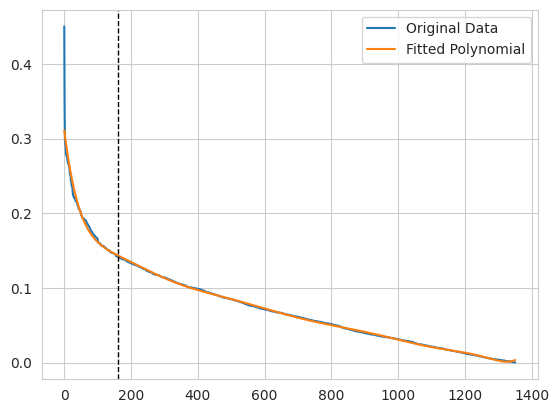

In [210]:
from biobank_olink.dataset import get_olink_panel_mapping
import matplotlib.pyplot as plt

panel_to_olinks = get_olink_panel_mapping()
olinks = panel_to_olinks["Cardiometabolic"]
# olink_subset = feat_imps.index.intersection(olinks)

y = feat_imps["SBP_high - SBP_low"].dropna().sort_values(ascending=False).values.reshape(-1)
x = np.arange(len(y))

coefficients = np.polyfit(x, y, 10)
polynomial = np.poly1d(coefficients)
y_fit = polynomial(x)

# first_derivative = np.gradient(y_fit)
# second_derivative = np.gradient(first_derivative)
# curvature = second_derivative / np.power((1 + first_derivative**2), 3/2)
# elbow_point = np.argmax(curvature)
elbow_point = find_elbow_point(y_fit)

plt.plot(x, y, label='Original Data')
plt.plot(x, y_fit, label='Fitted Polynomial')
plt.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
plt.legend()

[(-0.0014246681865135312, 0.01)]

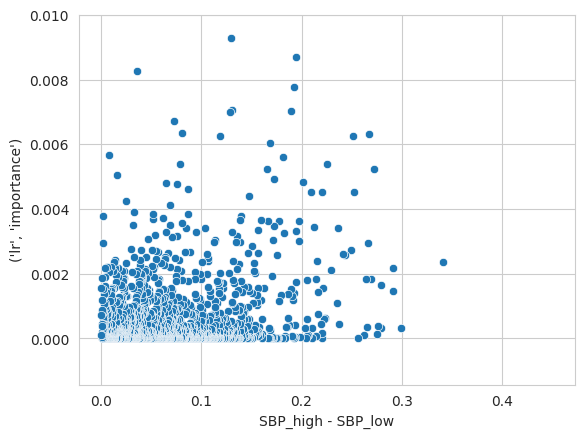

In [11]:
import seaborn as sns

ax = sns.scatterplot(data=feat_imps, x="SBP_high - SBP_low", y=("lr", "importance"))
ax.set(ylim=(None, 0.01))

In [12]:
feat_imps.corr()

,,lr,xgb,SBP_high - SBP_low
,,importance,importance,
lr,importance,1.000000,0.505053,0.277993
xgb,importance,0.505053,1.000000,0.498510
SBP_high - SBP_low,,0.277993,0.498510,1.000000


## Classification

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

x = ol_df.loc[chosen_cov_df.index]
y = chosen_cov_df.index.isin(high_cov_df.index)

est = XGBClassifier(tree_method="gpu_hist", random_state=42, n_estimators=1000)
scores = cross_val_score(est, x, y, scoring="accuracy", cv=5, n_jobs=5)
scores, scores.mean()

KeyboardInterrupt: 